In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

def load_csv_data(f, col='Date/Time'):
    df = pd.read_csv(f)

    df[col] = df[col].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
    df[col] = '2023/' + df[col]

    # handle 24:00:00 as next-day midnight
    mask_24 = df[col].str.contains(' 24:')
    df.loc[mask_24, col] = df.loc[mask_24, col].str.replace(' 24:', ' 00:', regex=False)
    df.loc[mask_24, col] = pd.to_datetime(df.loc[mask_24, col], format='%Y/%m/%d %H:%M:%S') + pd.Timedelta(days=1)

    # normal parse for others
    df.loc[~mask_24, col] = pd.to_datetime(df.loc[~mask_24, col], format='%Y/%m/%d %H:%M:%S')

    # shift +1 hour so 1:00 represents 00:00–01:00
    df[col] = pd.to_datetime(df[col]) - pd.Timedelta(hours=1)

    df = df.drop_duplicates(subset=col, keep='last').set_index(col)
    return df

p = Path("sims/csv")
csv_data = {f: load_csv_data(f) for f in sorted(p.glob("*.csv"))}

In [54]:
pd.read_csv('sims/csv/SS_Burlington_6A_tier1_gasfurnace_updated.csv')

,Date/Time,LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly),LIVING PLUG-IN LIGHTING1:Lights Electricity Rate [W](Hourly),INTGAINS1:Electric Equipment Electricity Rate [W](Hourly),EXTERIOR-LIGHTS_UNIT1:Exterior Lights Electricity Rate [W](Hourly),GARAGE-LIGHTS_UNIT1:Exterior Lights Electricity Rate [W](Hourly)
0,01/21 01:00:00,14.604759,3.651190,395.628514,30.589041,0.874738
1,01/21 02:00:00,14.604759,3.651190,364.269649,30.589041,0.874738
2,01/21 03:00:00,14.604759,3.651190,360.046233,30.589041,0.874738
3,01/21 04:00:00,14.604759,3.651190,354.978133,30.589041,0.874738
4,01/21 05:00:00,43.814276,10.953569,341.568787,30.589041,2.624213
...,...,...,...,...,...,...
8803,12/31 20:00:00,230.024948,57.506237,629.605773,30.589041,13.777117
8804,12/31 21:00:00,233.676137,58.419034,651.250781,30.589041,13.995801
8805,12/31 22:00:00,160.652344,40.163086,636.046482,30.589041,9.622113
8806,12/31 23:00:00,89.454146,22.363537,550.416719,30.589041,5.357768


In [8]:
df.isna().sum()

LIVING HARDWIRED LIGHTING1:Lights Electricity Rate [W](Hourly)        0
LIVING PLUG-IN LIGHTING1:Lights Electricity Rate [W](Hourly)          0
INTGAINS1:Electric Equipment Electricity Rate [W](Hourly)             0
EXTERIOR-LIGHTS_UNIT1:Exterior Lights Electricity Rate [W](Hourly)    0
GARAGE-LIGHTS_UNIT1:Exterior Lights Electricity Rate [W](Hourly)      0
dtype: int64

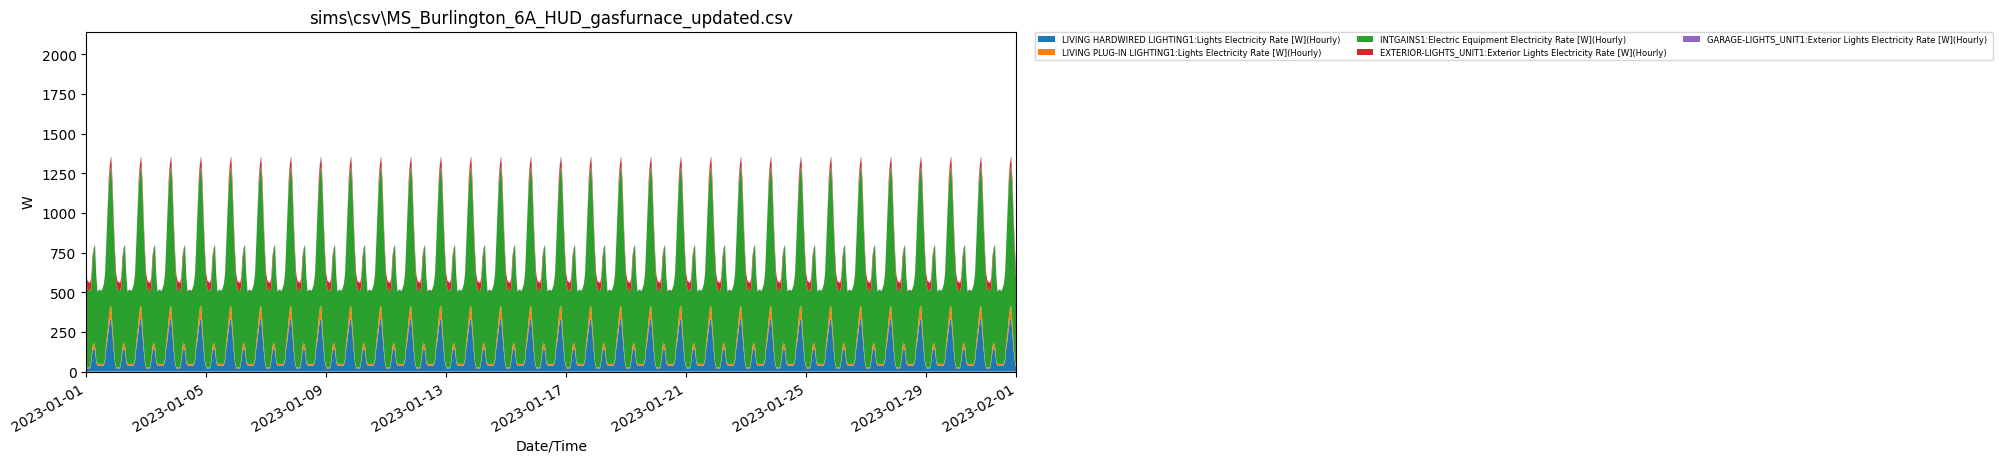

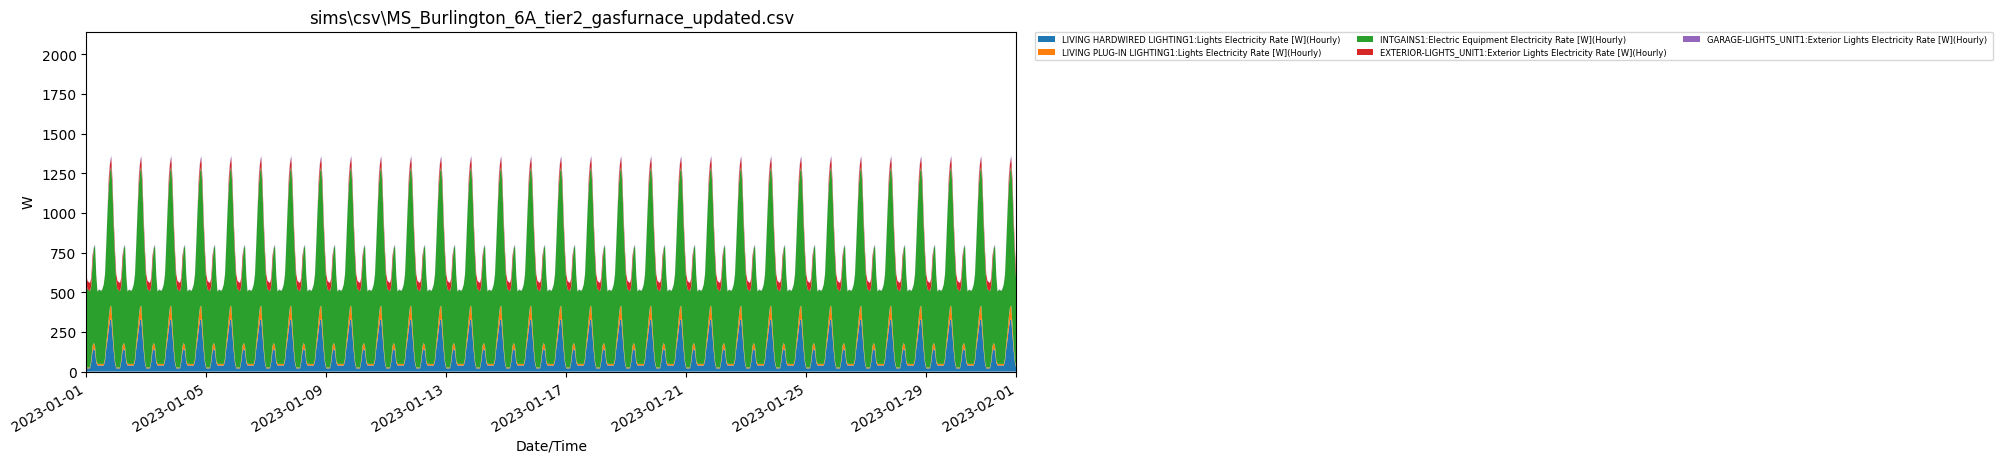

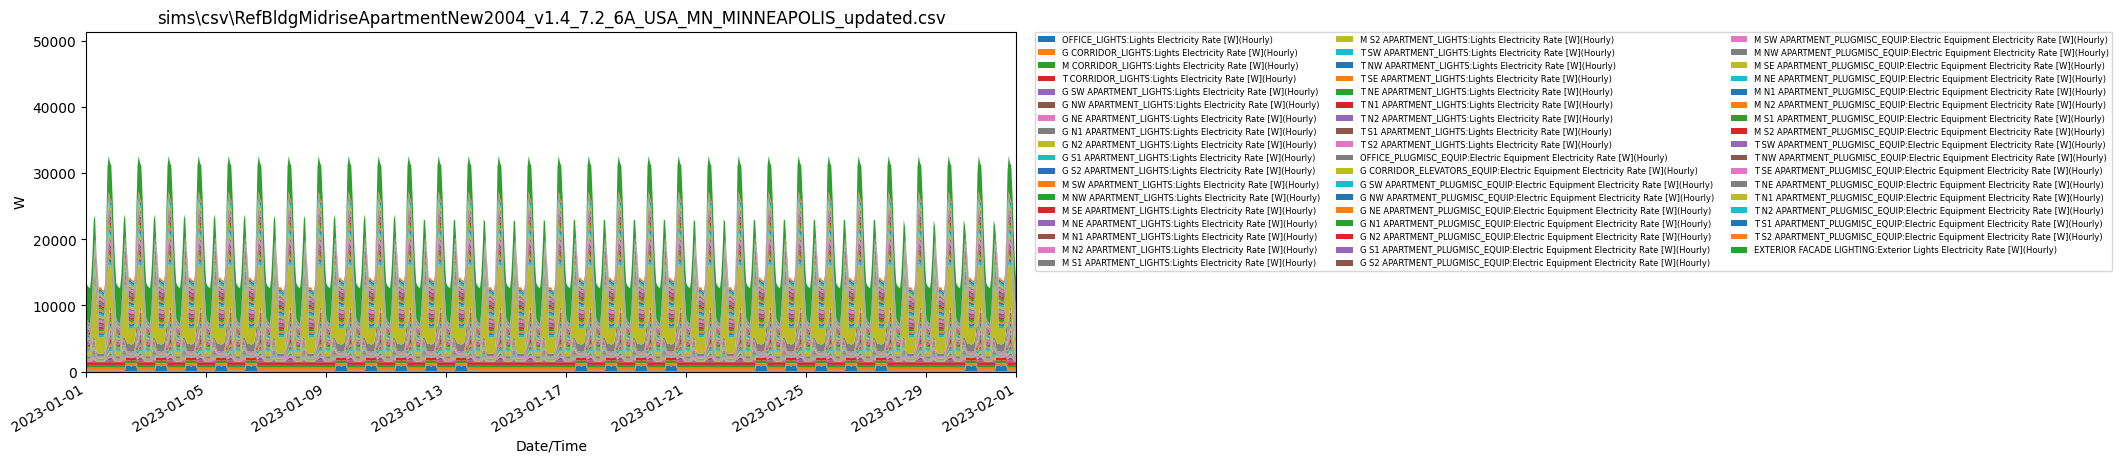

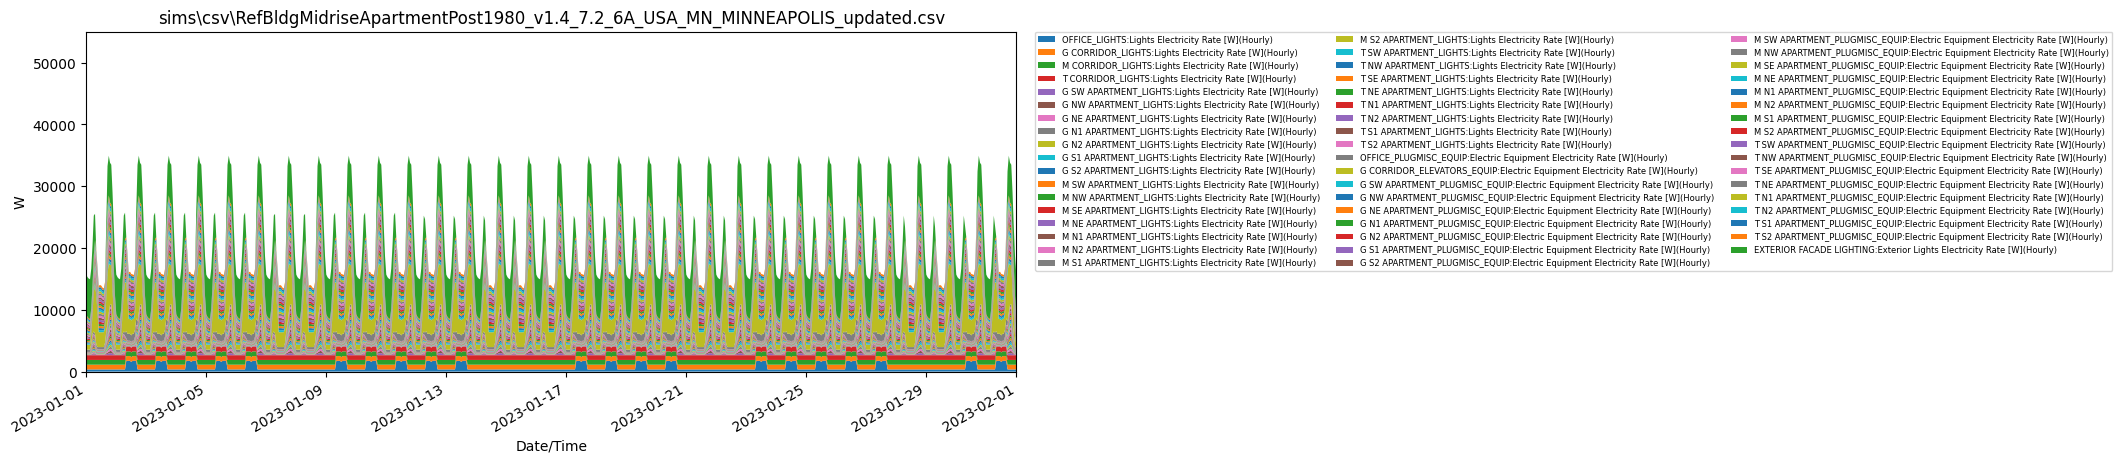

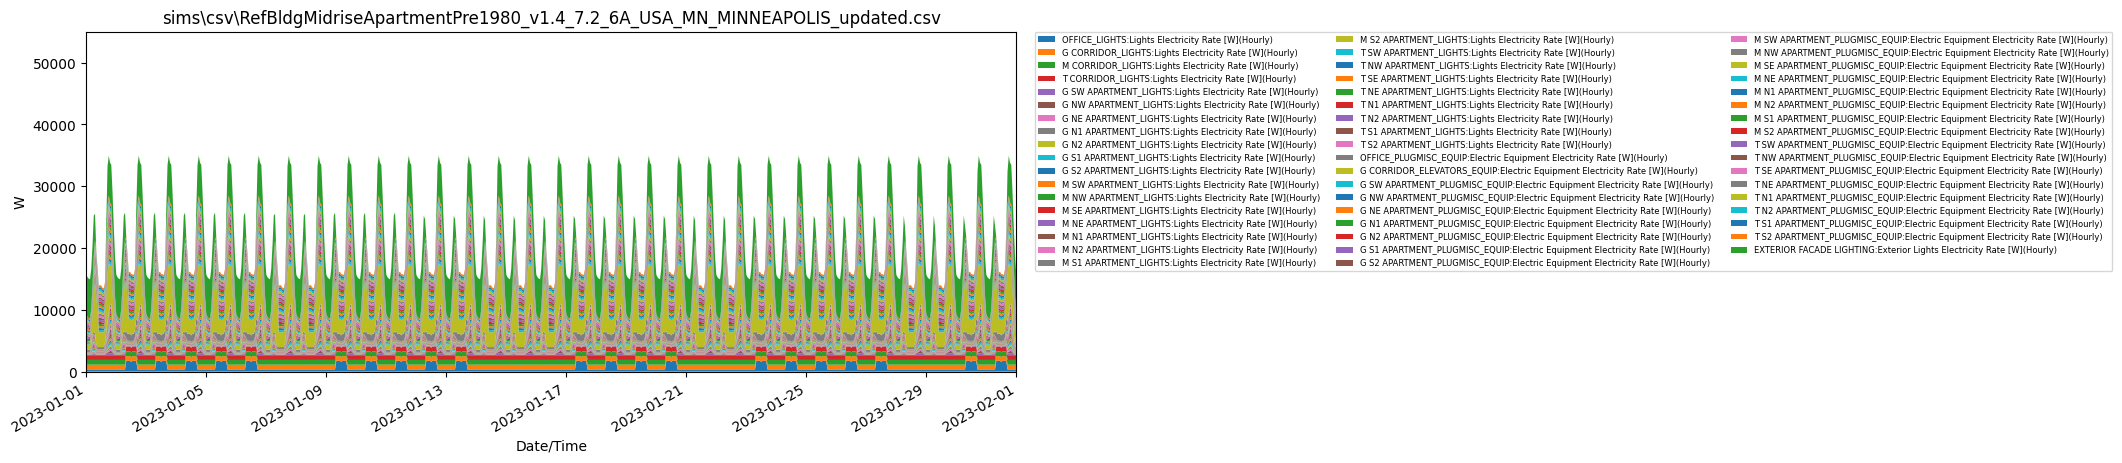

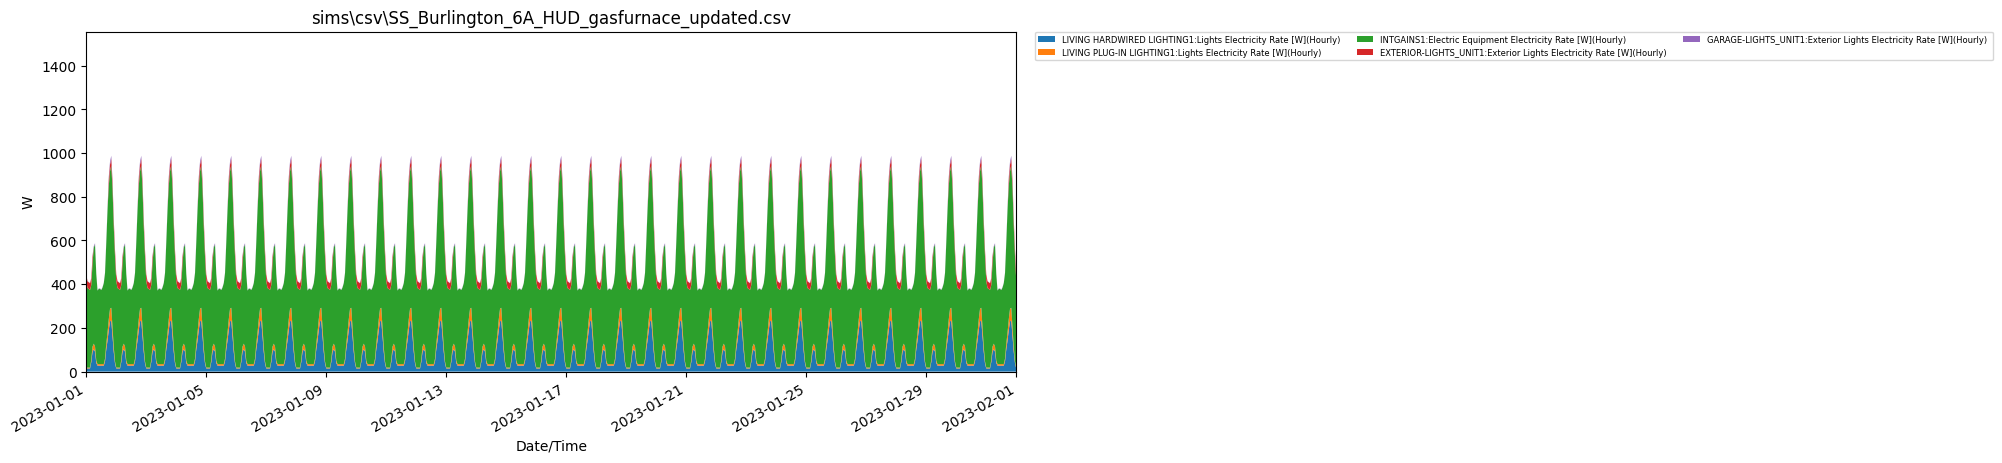

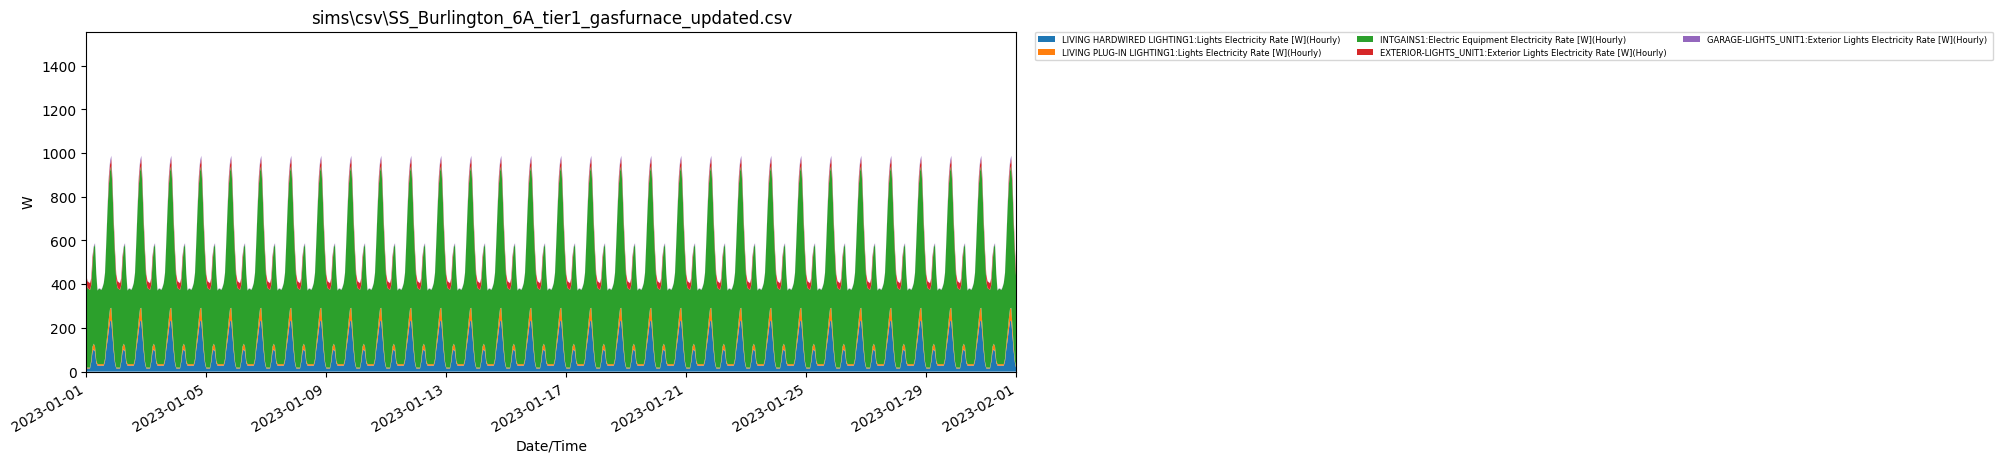

In [ ]:
for name, df in csv_data.items():
    cols = [c for c in df.columns if '[W]' in c]
    
    max_amplitude = df[cols].sum(axis=1).max()
    
    
    cum = np.zeros(len(df))
    fig, ax = plt.subplots(figsize=(12, 5))
    for col in cols:
        y = df[col].fillna(0).to_numpy()
        ax.fill_between(df.index, cum, cum + y, label=col, alpha=1, linewidth=0., edgecolor='k')
        cum += y

    ax.legend(loc='upper left', fontsize=6, ncol=3, bbox_to_anchor=(1.02, 1), borderaxespad=0.)
    ax.set_xlabel('Date/Time')
    ax.set_ylabel('W')
    ax.set_xlim(pd.Timestamp('2023-01-01'), pd.Timestamp('2023-02-01'))
    fig.autofmt_xdate()
    _, ymax = plt.ylim(0, None)
    plt.ylim(0, ymax*1.5)
    plt.title(name)